# 0. Prerequisite

In [ ]:
# Maximum rate at which stream output can be sent on iopub before they are limited.
# NotebookApp.iopub_data_rate_limit Float
# Default: 1000000 (bytes/sec)

In [ ]:
# https://research.google.com/colaboratory/local-runtimes.html

# jupyter notebook   --NotebookApp.allow_origin='https://colab.research.google.com'   --port=8888   --NotebookApp.port_retries=0 --NotebookApp.iopub_data_rate_limit=1.0e10

# Review

https://github.com/tensorflow/tensorboard

TensorBoard is a suite of web applications for inspecting and understanding your TensorFlow runs and graphs.


In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [3]:
# Clear any logs from previous runs
!rm -rf ./logs/

In [4]:
import tensorflow as tf
import datetime

In [5]:
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

11490434/11490434 [==============================] - 0s 0us/step


In [6]:
def create_model():
  return tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28), name='layers_flatten'),
    tf.keras.layers.Dense(512, activation='relu', name='layers_dense'),
    tf.keras.layers.Dropout(0.2, name='layers_dropout'),
    tf.keras.layers.Dense(10, activation='softmax', name='layers_dense_2')
  ])

model = create_model()

In [7]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

You're now ready to define, train and evaluate your model.

To log the loss scalar as you train, you'll do the following:

* Create the Keras TensorBoard callback
* Specify a log directory
* Pass the TensorBoard callback to Keras' Model.fit().

In [8]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [9]:
model.fit(x=x_train, 
          y=y_train, 
          epochs=5, 
          validation_data=(x_test, y_test), 
          callbacks=[tensorboard_callback])

Epoch 1/5
1875/1875 [==============================] - 9s 4ms/step - loss: 0.2233 - accuracy: 0.9330 - val_loss: 0.1082 - val_accuracy: 0.9652
Epoch 2/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0988 - accuracy: 0.9696 - val_loss: 0.0802 - val_accuracy: 0.9752
Epoch 3/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0694 - accuracy: 0.9788 - val_loss: 0.0738 - val_accuracy: 0.9759
Epoch 4/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0545 - accuracy: 0.9823 - val_loss: 0.0652 - val_accuracy: 0.9788
Epoch 5/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0433 - accuracy: 0.9861 - val_loss: 0.0666 - val_accuracy: 0.9796


In [11]:
tensorboard --logdir logs/fit --port 6007

Launching TensorBoard...

**How TensorBoard gets data from TensorFlow**

For this, you need **summary ops**. Summary ops are ops, just like tf.matmul and tf.nn.relu, which means they take in tensors, produce tensors, and are evaluated from within a TensorFlow graph. 

However, summary ops have a twist: 

* The tensors they produce contain serialized protobufs, which are written to disk and sent to TensorBoard. 

* To visualize the summary data in TensorBoard, you should evaluate the summary op, retrieve the result, and then write that result to disk using a **summary.FileWriter**. 

The supported summary ops include:

* tf.summary.scalar
* tf.summary.image
* tf.summary.audio
* tf.summary.text
* tf.summary.histogram

In [14]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [15]:
from datetime import datetime
from packaging import version

import tensorflow as tf
from tensorflow import keras
from keras import backend as K

import numpy as np

print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."

TensorFlow version:  2.10.0


In [16]:
# Clear any logs from previous runs
!rm -rf ./logs/

In [17]:
data_size = 1000
# 80% of the data is for training.
train_pct = 0.8

train_size = int(data_size * train_pct)

# Create some input data between -1 and 1 and randomize it.
x = np.linspace(-1, 1, data_size)
np.random.shuffle(x)

# Generate the output data.
# y = 0.5x + 2 + noise
y = 0.5 * x + 2 + np.random.normal(0, 0.05, (data_size, ))

# Split into test and train pairs.
x_train, y_train = x[:train_size], y[:train_size]
x_test, y_test = x[train_size:], y[train_size:]

What if you want to log custom values, such as a dynamic learning rate? To do that, you need to use the TensorFlow Summary API.

Retrain the regression model and log a custom learning rate. Here's how:

1. Create a file writer, using **tf.summary.create_file_writer()**.
2. Define a custom learning rate function. This will be passed to the Keras LearningRateScheduler callback.
3. Inside the learning rate function, use **tf.summary.scalar()** to log the custom learning rate.
4. Pass the LearningRateScheduler callback to Model.fit().

In [18]:
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer(logdir + "/metrics")
file_writer.set_as_default()

In [19]:
def lr_schedule(epoch):
  """
  Returns a custom learning rate that decreases as epochs progress.
  """
  learning_rate = 0.2
  if epoch > 10:
    learning_rate = 0.02
  if epoch > 20:
    learning_rate = 0.01
  if epoch > 50:
    learning_rate = 0.005

  tf.summary.scalar('learning rate', data=learning_rate, step=epoch)
  return learning_rate

lr_callback = keras.callbacks.LearningRateScheduler(lr_schedule)
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [20]:
model = keras.models.Sequential([
    keras.layers.Dense(16, input_dim=1),
    keras.layers.Dense(1),
])

model.compile(
    loss='mse', # keras.losses.mean_squared_error
    optimizer=keras.optimizers.SGD(),
)

training_history = model.fit(
    x_train, # input
    y_train, # output
    batch_size=train_size,
    verbose=1, # Suppress chatty output; use Tensorboard instead
    epochs=100,
    validation_data=(x_test, y_test),
    callbacks=[tensorboard_callback, lr_callback],
)

Epoch 1/100
1/1 [==============================] - 1s 539ms/step - loss: 4.3884 - val_loss: 0.4416 - lr: 0.2000
Epoch 2/100
1/1 [==============================] - 0s 150ms/step - loss: 0.4643 - val_loss: 0.2321 - lr: 0.2000
Epoch 3/100
1/1 [==============================] - 0s 125ms/step - loss: 0.2282 - val_loss: 0.0317 - lr: 0.2000
Epoch 4/100
1/1 [==============================] - 0s 125ms/step - loss: 0.0325 - val_loss: 0.0121 - lr: 0.2000
Epoch 5/100
1/1 [==============================] - 0s 109ms/step - loss: 0.0119 - val_loss: 0.0048 - lr: 0.2000
Epoch 6/100
1/1 [==============================] - 0s 84ms/step - loss: 0.0048 - val_loss: 0.0031 - lr: 0.2000
Epoch 7/100
1/1 [==============================] - 0s 94ms/step - loss: 0.0031 - val_loss: 0.0027 - lr: 0.2000
Epoch 8/100
1/1 [==============================] - 0s 94ms/step - loss: 0.0027 - val_loss: 0.0025 - lr: 0.2000
Epoch 9/100
1/1 [==============================] - 0s 94ms/step - loss: 0.0026 - val_loss: 0.0025 - lr: 0.2

In [21]:
%tensorboard --logdir logs/scalars --port 6009

Launching TensorBoard...

# Step32 - Weight Initialization & The Vanishing Gradient Problem


<img src="https://global-uploads.webflow.com/5ef788f07804fb7d78a4127a/6245a9aca7defe61cea5ea7d_Engati-vanishing-point-problem.jpg" width=400><img src="https://miro.medium.com/max/1178/1*54WxyNRIoO6OX8Jwa-caeQ.webp" width=400>



* gradient vanishing problem, 미분값 최대 0.25, 
* 이것을 $0.25^7 = 0.000061035 $


In [22]:
%load_ext tensorboard
#%reload_ext tensorboard
!rm -rf ./logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [23]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [24]:
#1
(x_train, y_train), (x_test, y_test) = mnist.load_data()

#2:normalize images
x_train = x_train.astype('float32')
x_test  = x_test.astype('float32')
x_train /= 255.0 # [0, 1]
x_test  /= 255.0

#3: one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train) # (60000, 10)
y_test = tf.keras.utils.to_categorical(y_test)   # (10000, 10)

In [25]:
#4: build a model
init = tf.keras.initializers.Constant(0.1)
##init = tf.keras.initializers.RandomUniform(-0.5, 0.5) # 'random_uniform’

In [26]:
# kernel_initializer='glorot_uniform',

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
model.add(tf.keras.layers.Dense(units=5, activation='sigmoid', kernel_initializer=init))
model.add(tf.keras.layers.Dense(units=5, activation='sigmoid', kernel_initializer=init))
model.add(tf.keras.layers.Dense(units=5, activation='sigmoid', kernel_initializer=init))
model.add(tf.keras.layers.Dense(units=5, activation='sigmoid', kernel_initializer=init))
model.add(tf.keras.layers.Dense(units=5, activation='sigmoid', kernel_initializer=init))
model.add(tf.keras.layers.Dense(units=10,activation='softmax', kernel_initializer=init))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 5)                 3925      
                                                                 
 dense_3 (Dense)             (None, 5)                 30        
                                                                 
 dense_4 (Dense)             (None, 5)                 30        
                                                                 
 dense_5 (Dense)             (None, 5)                 30        
                                                                 
 dense_6 (Dense)             (None, 5)                 30        
                                                                 
 dense_7 (Dense)             (None, 10)               

In [27]:
opt = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
log_dir = "./logs/3201/"
file_writer = tf.summary.create_file_writer(log_dir + "/gradient")
file_writer.set_as_default()

In [29]:
#6:  calculate averages and histograms of gradients in layers
class GradientCallback(tf.keras.callbacks.Callback):
  def __init__(self, freq=10):
  ##        super(GradientCallback, self).__init__()
      self.freq = freq

  def on_epoch_end(self, epoch, logs):
      if epoch%self.freq != 0:
          return

      with tf.GradientTape() as tape:
          y_pred = model(x_train)  # tensor, logits           
          loss   = tf.keras.losses.binary_crossentropy(y_train, y_pred)
      grads = tape.gradient(loss, model.trainable_weights)

      for n in range(1, len(model.layers)):
          i2 = (n-1)*2 # weights
          i1 = i2 + 1  # biases

          bias_avg   = tf.reduce_mean(tf.abs(grads[i1]))
          weight_avg = tf.reduce_mean(tf.abs(grads[i2]))
          
          tf.summary.scalar("layer_%d/avg/bias"%n, data=bias_avg, step=epoch)   
          tf.summary.scalar("layer_%d/avg/weight"%n, data=weight_avg, step=epoch)
          
          tf.summary.histogram("layer_%d/hist/bias"%n, data=grads[i1], step=epoch)
          tf.summary.histogram("layer_%d/hist/weight"%n, data=grads[i2], step=epoch)

          tf.print('epoch: {}, layer-{}, i1: {}, i2: {}'.format(epoch, n, i1, i2))
      
      feature_extractor = keras.Model(
          inputs=model.inputs,
          outputs=[layer.output for layer in model.layers],
      )
      features = feature_extractor(x_train)
      for i, f in enumerate(features):
        print('type_i: {}, type_f: {}'.format(type(i), type(f)))
        output_avg = tf.reduce_mean(tf.abs(f))
        tf.summary.scalar("layer_%d/avg/output"%i, data=output_avg, step=epoch)        
        tf.summary.histogram("layer_%d/hist/output"%i, data=f, step=epoch)
      
  def on_train_end(self, logs):
      tf.summary.flush()

callback1 = GradientCallback() # freq = 10
callback2 = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq= 10) #profile_batch=0      

In [30]:
#7: train and evaluate the model
ret = model.fit(x_train, y_train, epochs=101, batch_size=200, validation_split=0.2,
                 verbose=1, callbacks=[callback1, callback2])

Epoch 1/101
233/240 [============================>.] - ETA: 0s - loss: 2.2573 - accuracy: 0.1257epoch: 0, layer-1, i1: 1, i2: 0
epoch: 0, layer-2, i1: 3, i2: 2
epoch: 0, layer-3, i1: 5, i2: 4
epoch: 0, layer-4, i1: 7, i2: 6
epoch: 0, layer-5, i1: 9, i2: 8
epoch: 0, layer-6, i1: 11, i2: 10
type_i: <class 'int'>, type_f: <class 'tensorflow.python.framework.ops.EagerTensor'>
type_i: <class 'int'>, type_f: <class 'tensorflow.python.framework.ops.EagerTensor'>
type_i: <class 'int'>, type_f: <class 'tensorflow.python.framework.ops.EagerTensor'>
type_i: <class 'int'>, type_f: <class 'tensorflow.python.framework.ops.EagerTensor'>
type_i: <class 'int'>, type_f: <class 'tensorflow.python.framework.ops.EagerTensor'>
type_i: <class 'int'>, type_f: <class 'tensorflow.python.framework.ops.EagerTensor'>
type_i: <class 'int'>, type_f: <class 'tensorflow.python.framework.ops.EagerTensor'>
240/240 [==============================] - 56s 231ms/step - loss: 2.2505 - accuracy: 0.1283 - val_loss: 2.0051 - va

In [31]:
train_loss, train_acc = model.evaluate(x_train, y_train, verbose=1)
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=1)

313/313 [==============================] - 1s 3ms/step - loss: 1.5955 - accuracy: 0.3487


In [32]:
print('train_loss: {:.2f}, train_acc: {:.2f}, test_loss: {:.2f}, test_acc: {:.2f}'\
      .format(train_loss, train_acc, test_loss, test_acc))

train_loss: 1.57, train_acc: 0.36, test_loss: 1.60, test_acc: 0.35


In [36]:
%tensorboard --logdir ./logs/3201

Launching TensorBoard...

In [37]:
from tensorboard import notebook
notebook.list() # View open TensorBoard instances

Known TensorBoard instances:
  - port 6006: logdir ./logs/3201 (started 0:19:25 ago; pid 12172)
  - port 6007: logdir logs/fit (started 0:35:22 ago; pid 3124)
  - port 6009: logdir logs/scalars (started 0:31:34 ago; pid 8296)


In [39]:
# Control TensorBoard display. If no port is provided, 
# the most recently launched TensorBoard is used
notebook.display(port=6007, height=1000)

Selecting TensorBoard with logdir logs/fit (started 0:37:26 ago; port 6007, pid 3124).



https://www.deeplearning.ai/ai-notes/initialization/index.html


| Initializers | Activation Functions|
|--------------|---------------------|
| tf.keras.initializers.GlorotNormal | Sigmoid, Tanh |
| tf.keras.initializers.HeNormal | ReLU, LeakyReLu |

In [40]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import datetime
#1
(x_train, y_train), (x_test, y_test) = mnist.load_data()

#2: normalize images
x_train = x_train.astype('float32')
x_test  = x_test.astype('float32')
x_train /= 255.0 # [0, 1]
x_test  /= 255.0

#3: one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train) # (60000, 10)
y_test = tf.keras.utils.to_categorical(y_test)   # (10000, 10)

#4: build a model
##init = tf.keras.initializers.glorot_uniform()    # 'glorot_uniform'
init = tf.keras.initializers.glorot_normal()       # 'glorot_normal'

n = 100 # 5
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
model.add(tf.keras.layers.Dense(units=n, activation='sigmoid', kernel_initializer=init))
model.add(tf.keras.layers.Dense(units=n, activation='sigmoid', kernel_initializer=init))
model.add(tf.keras.layers.Dense(units=n, activation='sigmoid', kernel_initializer=init))
model.add(tf.keras.layers.Dense(units=n, activation='sigmoid', kernel_initializer=init))
model.add(tf.keras.layers.Dense(units=n, activation='sigmoid', kernel_initializer=init))
model.add(tf.keras.layers.Dense(units=n, activation='sigmoid', kernel_initializer=init))
model.add(tf.keras.layers.Dense(units=10,activation='softmax', kernel_initializer=init))
model.summary()

opt = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

#5: creates a summary file writer for the given log directory
#import os
#path = "c:\\tmp\\logs\\"
#if not os.path.isdir(path):
#    os.mkdir(path)
##logdir = path + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = './logs/' + "3202"
file_writer = tf.summary.create_file_writer(logdir + "/gradient")
file_writer.set_as_default()

#6:  calculate averages and histograms of gradients in layers
class GradientCallback(tf.keras.callbacks.Callback):
    
    def __init__(self, freq=10):
##        super(GradientCallback, self).__init__()
        self.freq = freq

    def on_epoch_end(self, epoch, logs):
        if epoch%self.freq != 0:
            return
        with tf.GradientTape() as tape:
            y_pred = model(x_train)  # tensor, logits
            loss   = tf.keras.losses.binary_crossentropy(y_train, y_pred)
        grads = tape.gradient(loss, model.trainable_weights)
        for n in range(1, len(model.layers)):
            i2 = (n-1)*2 # weights
            i1 = i2 + 1  # biases

            bias_avg   = tf.reduce_mean(tf.abs(grads[i1]))
            weight_avg = tf.reduce_mean(tf.abs(grads[i2]))
            
            tf.summary.scalar("layer_%d/avg/bias"%n, data=bias_avg, step=epoch)   
            tf.summary.scalar("layer_%d/avg/weight"%n, data=weight_avg, step=epoch)
##            
            tf.summary.histogram("layer_%d/hist/bias"%n, data=grads[i1], step=epoch)
            tf.summary.histogram("layer_%d/hist/weight"%n, data=grads[i2], step=epoch)
            
    def on_train_end(self, logs):
        tf.summary.flush()

callback1 = GradientCallback() # freq = 10
callback2 = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq= 10) #profile_batch=0       
                                  
#7: train and evaluate the model
ret = model.fit(x_train, y_train, epochs=101, batch_size=200, validation_split=0.2,
                 verbose=2, callbacks=[callback1, callback2])

train_loss, train_acc = model.evaluate(x_train, y_train, verbose=2)
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_8 (Dense)             (None, 100)               78500     
                                                                 
 dense_9 (Dense)             (None, 100)               10100     
                                                                 
 dense_10 (Dense)            (None, 100)               10100     
                                                                 
 dense_11 (Dense)            (None, 100)               10100     
                                                                 
 dense_12 (Dense)            (None, 100)               10100     
                                                                 
 dense_13 (Dense)            (None, 100)              

D:\sw15\tensorflow\venv\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/101
240/240 - 5s - loss: 1.4270 - accuracy: 0.3959 - val_loss: 1.0027 - val_accuracy: 0.6378 - 5s/epoch - 22ms/step
Epoch 2/101
240/240 - 2s - loss: 0.4264 - accuracy: 0.8788 - val_loss: 0.2509 - val_accuracy: 0.9373 - 2s/epoch - 7ms/step
Epoch 3/101
240/240 - 2s - loss: 0.2334 - accuracy: 0.9394 - val_loss: 0.1712 - val_accuracy: 0.9559 - 2s/epoch - 8ms/step
Epoch 4/101
240/240 - 2s - loss: 0.1665 - accuracy: 0.9559 - val_loss: 0.1545 - val_accuracy: 0.9587 - 2s/epoch - 7ms/step
Epoch 5/101
240/240 - 2s - loss: 0.1316 - accuracy: 0.9652 - val_loss: 0.1511 - val_accuracy: 0.9636 - 2s/epoch - 7ms/step
Epoch 6/101
240/240 - 2s - loss: 0.1084 - accuracy: 0.9715 - val_loss: 0.1316 - val_accuracy: 0.9652 - 2s/epoch - 7ms/step
Epoch 7/101
240/240 - 2s - loss: 0.0893 - accuracy: 0.9769 - val_loss: 0.1248 - val_accuracy: 0.9704 - 2s/epoch - 7ms/step
Epoch 8/101
240/240 - 2s - loss: 0.0767 - accuracy: 0.9801 - val_loss: 0.1388 - val_accuracy: 0.9681 - 2s/epoch - 7ms/step
Epoch 9/101
240

In [42]:
import tensorboard
%tensorboard --logdir ./logs/3202 --port 6010

Launching TensorBoard...


<img src="https://production-media.paperswithcode.com/methods/Screen_Shot_2020-05-27_at_1.18.53_PM_wFylRBX.png" width="400"/>


In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import datetime
#1
(x_train, y_train), (x_test, y_test) = mnist.load_data()

#2: normalize images
x_train = x_train.astype('float32')
x_test  = x_test.astype('float32')
x_train /= 255.0 # [0, 1]
x_test  /= 255.0

#3: one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train) # (60000, 10)
y_test = tf.keras.utils.to_categorical(y_test)   # (10000, 10)

#4: build a model
#4-1
##init = tf.keras.initializers.he_normal() # 'he_normal'
##act =  tf.keras.activations.relu         # 'relu'

#4-2
##init = tf.keras.initializers.he_normal()   # 'he_normal'
##act = tf.keras.layers.LeakyReLU(alpha=0.3)

#4-3
init =  tf.keras.initializers.he_uniform() # 'he_uniform'
act = tf.keras.layers.LeakyReLU(alpha=0.3)

n = 100
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
model.add(tf.keras.layers.Dense(units=n, activation=act, kernel_initializer=init))
model.add(tf.keras.layers.Dense(units=n, activation=act, kernel_initializer=init))
model.add(tf.keras.layers.Dense(units=n, activation=act, kernel_initializer=init))
model.add(tf.keras.layers.Dense(units=n, activation=act, kernel_initializer=init))
model.add(tf.keras.layers.Dense(units=n, activation=act, kernel_initializer=init))
model.add(tf.keras.layers.Dense(units=n, activation=act, kernel_initializer=init))
model.add(tf.keras.layers.Dense(units=10,activation='softmax', kernel_initializer=init))
model.summary()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

#5: creates a summary file writer for the given log directory
#import os
#path = "c:\\tmp\\logs\\"
#if not os.path.isdir(path):
#    os.mkdir(path)
##logdir = path + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = './logs/' + "3203"

file_writer = tf.summary.create_file_writer(logdir + "/gradient")
file_writer.set_as_default()

#6:  calculate averages and histograms of gradients in layers
class GradientCallback(tf.keras.callbacks.Callback):
    
    def __init__(self, freq=10):
##        super(GradientCallback, self).__init__()
        self.freq = freq

    def on_epoch_end(self, epoch, logs):
        if epoch%self.freq != 0:
            return
        with tf.GradientTape() as tape:
            y_pred = model(x_train)  # tensor, logits
            loss   = tf.keras.losses.binary_crossentropy(y_train, y_pred)
        grads = tape.gradient(loss, model.trainable_weights)
        for n in range(1, len(model.layers)):
            i2 = (n-1)*2 # weights
            i1 = i2 + 1  # biases

            bias_avg   = tf.reduce_mean(tf.abs(grads[i1]))
            weight_avg = tf.reduce_mean(tf.abs(grads[i2]))
            
            tf.summary.scalar("layer_%d/avg/bias"%n, data=bias_avg, step=epoch)   
            tf.summary.scalar("layer_%d/avg/weight"%n, data=weight_avg, step=epoch)
##            
            tf.summary.histogram("layer_%d/hist/bias"%n, data=grads[i1], step=epoch)
            tf.summary.histogram("layer_%d/hist/weight"%n, data=grads[i2], step=epoch)
            
    def on_train_end(self, logs):
        tf.summary.flush()

callback1 = GradientCallback() # freq = 10
callback2 = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq= 10) #profile_batch=0      
                                  
#7: train and evaluate the model
ret = model.fit(x_train, y_train, epochs=101, batch_size=200, validation_split=0.2,
                 verbose=2, callbacks=[callback1, callback2])

train_loss, train_acc = model.evaluate(x_train, y_train, verbose=2)
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_13 (Flatten)        (None, 784)               0         
                                                                 
 dense_87 (Dense)            (None, 100)               78500     
                                                                 
 dense_88 (Dense)            (None, 100)               10100     
                                                                 
 dense_89 (Dense)            (None, 100)               10100     
                                                                 
 dense_90 (Dense)            (None, 100)               10100     
                                                                 
 dense_91 (Dense)            (None, 100)               10100     
                                                                 
 dense_92 (Dense)            (None, 100)             

In [ ]:
%tensorboard --logdir ./logs/3203 --port 6011

# Step33 - Batch Normalization


* 데이터를 정규화하면 정확도가 높아짐
* 레이어의 출력을 평균 0, 분산 1로 정규화함
* 가중치 초기화에 영향을 덜 받음
* 학습 속도를 빠르게 함
* Overfitting 방지

<img src="https://gaussian37.github.io/assets/img/dl/concept/batchnorm/2.png" width="400"/>


<img src="https://gaussian37.github.io/assets/img/dl/concept/batchnorm/4.png" width="400"/>

<img src="https://d3i71xaburhd42.cloudfront.net/94be567c32ae76bdaadabd4975807a94181e39b3/2-Figure1-1.png" width="400"/>



In [43]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import datetime
#1
(x_train, y_train), (x_test, y_test) = mnist.load_data()

#2:normalize images
x_train = x_train.astype('float32')
x_test  = x_test.astype('float32')
x_train /= 255.0 # [0, 1]
x_test  /= 255.0

#3: one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train) # (60000, 10)
y_test = tf.keras.utils.to_categorical(y_test)   # (10000, 10)

#4: build a model
##init = tf.keras.initializers.RandomNormal(mean = 0.0, stddev = 1.0 )
##init = tf.keras.initializers.RandomUniform(-0.5, 0.5)
init = tf.keras.initializers.RandomUniform(0.0, 1.0) 

n = 100
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
model.add(tf.keras.layers.Dense(units=n, activation='sigmoid', kernel_initializer=init))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(units=n, activation='sigmoid', kernel_initializer=init))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(units=n, activation='sigmoid', kernel_initializer=init))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(units=n, activation='sigmoid', kernel_initializer=init))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(units=n, activation='sigmoid', kernel_initializer=init))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(units=n, activation='sigmoid', kernel_initializer=init))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(units=10, activation='softmax', kernel_initializer=init))
model.summary()

opt = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

#5: creates a summary file writer for the given log directory
#import os
#path = "c:\\tmp\\logs\\"
#if not os.path.isdir(path):
#    os.mkdir(path)
##logdir = path + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = './logs/' + "3301"

file_writer = tf.summary.create_file_writer(logdir + "/gradient")
file_writer.set_as_default()

#6:  calculate averages and histograms of gradients in layers
class GradientCallback(tf.keras.callbacks.Callback): 
  def __init__(self, freq=10):
##        super(GradientCallback, self).__init__()
      self.freq = freq

  def on_epoch_end(self, epoch, logs):
    if epoch%self.freq != 0:
        return

    with tf.GradientTape() as tape:
        y_pred = model(x_train)  # tensor, logits           
        loss   = tf.keras.losses.binary_crossentropy(y_train, y_pred)
    grads = tape.gradient(loss, model.trainable_weights)

    for n in range(1, len(model.layers)):
        i2 = (n-1)*2 # weights
        i1 = i2 + 1  # biases

        bias_avg   = tf.reduce_mean(tf.abs(grads[i1]))
        weight_avg = tf.reduce_mean(tf.abs(grads[i2]))
        
        tf.summary.scalar("layer_%d/avg/bias"%n, data=bias_avg, step=epoch)   
        tf.summary.scalar("layer_%d/avg/weight"%n, data=weight_avg, step=epoch)
        
        tf.summary.histogram("layer_%d/hist/bias"%n, data=grads[i1], step=epoch)
        tf.summary.histogram("layer_%d/hist/weight"%n, data=grads[i2], step=epoch)

        tf.print('epoch: {}, layer-{}, i1: {}, i2: {}'.format(epoch, n, i1, i2))
    
    feature_extractor = keras.Model(
        inputs=model.inputs,
        outputs=[layer.output for layer in model.layers],
    )
    features = feature_extractor(x_train)
    for i, f in enumerate(features):
      print('type_i: {}, type_f: {}'.format(type(i), type(f)))
      output_avg = tf.reduce_mean(tf.abs(f))
      tf.summary.scalar("layer_%d/avg/output"%i, data=output_avg, step=epoch)        
      tf.summary.histogram("layer_%d/hist/output"%i, data=f, step=epoch)
      
  def on_train_end(self, logs):
      tf.summary.flush()

callback1 = GradientCallback() # freq = 10
callback2 = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq= 10, profile_batch=0) 

#7: train and evaluate the model
ret = model.fit(x_train, y_train, epochs=101, batch_size=200, validation_split=0.2,
                 verbose=2, callbacks=[callback1, callback2])

train_loss, train_acc = model.evaluate(x_train, y_train, verbose=2)
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_15 (Dense)            (None, 100)               78500     
                                                                 
 batch_normalization (BatchN  (None, 100)              400       
 ormalization)                                                   
                                                                 
 dense_16 (Dense)            (None, 100)               10100     
                                                                 
 batch_normalization_1 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                                 
 dense_17 (Dense)            (None, 100)              

D:\sw15\tensorflow\venv\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/101
epoch: 0, layer-1, i1: 1, i2: 0
epoch: 0, layer-2, i1: 3, i2: 2
epoch: 0, layer-3, i1: 5, i2: 4
epoch: 0, layer-4, i1: 7, i2: 6
epoch: 0, layer-5, i1: 9, i2: 8
epoch: 0, layer-6, i1: 11, i2: 10
epoch: 0, layer-7, i1: 13, i2: 12
epoch: 0, layer-8, i1: 15, i2: 14
epoch: 0, layer-9, i1: 17, i2: 16
epoch: 0, layer-10, i1: 19, i2: 18
epoch: 0, layer-11, i1: 21, i2: 20
epoch: 0, layer-12, i1: 23, i2: 22
epoch: 0, layer-13, i1: 25, i2: 24
type_i: <class 'int'>, type_f: <class 'tensorflow.python.framework.ops.EagerTensor'>
type_i: <class 'int'>, type_f: <class 'tensorflow.python.framework.ops.EagerTensor'>
type_i: <class 'int'>, type_f: <class 'tensorflow.python.framework.ops.EagerTensor'>
type_i: <class 'int'>, type_f: <class 'tensorflow.python.framework.ops.EagerTensor'>
type_i: <class 'int'>, type_f: <class 'tensorflow.python.framework.ops.EagerTensor'>
type_i: <class 'int'>, type_f: <class 'tensorflow.python.framework.ops.EagerTensor'>
type_i: <class 'int'>, type_f: <class 'ten

In [ ]:
%tensorboard --logdir ./logs/3301 --port 6013

# Step34 Overfit & Regularization


https://playground.tensorflow.org/

https://deeperplayground.org/

<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*_7OPgojau8hkiPUiHoGK_w.png" width="400"/>

|   |   |
|---|---|

| <img src="https://developers.google.com/static/machine-learning/crash-course/images/HighLambda.svg" width="200"/> | <img src="https://developers.google.com/static/machine-learning/crash-course/images/LowLambda.svg" width="200"/> |


When choosing a lambda value, the goal is to strike the right balance between simplicity and training-data fit:

* If your lambda value is too high, your model will be simple, but you run the risk of underfitting your data. Your model won't learn enough about the training data to make useful predictions.

* If your lambda value is too low, your model will be more complex, and you run the risk of overfitting your data. Your model will learn too much about the particularities of the training data, and won't be able to generalize to new data.


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 dense_22 (Dense)            (None, 100)               78500     
                                                                 
 dense_23 (Dense)            (None, 100)               10100     
                                                                 
 dense_24 (Dense)            (None, 10)                1010      
                                                                 
Total params: 89,610
Trainable params: 89,610
Non-trainable params: 0
_________________________________________________________________
epoch: 0, layer-1, i1: 1, i2: 0
epoch: 0, layer-2, i1: 3, i2: 2
epoch: 0, layer-3, i1: 5, i2: 4
type_i: <class 'int'>, type_f: <class 'tensorflow.python.framework.ops.EagerTensor'>
t

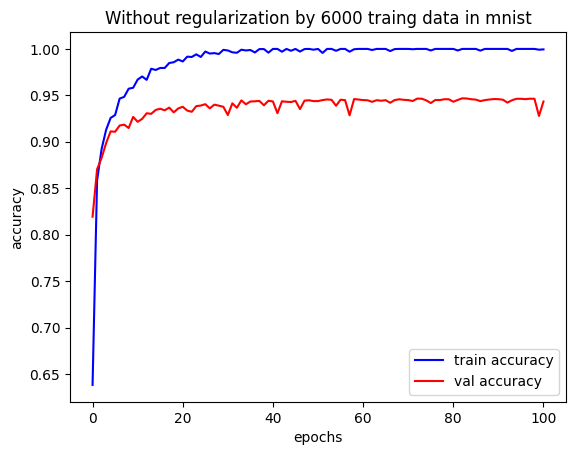

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 dense_25 (Dense)            (None, 100)               78500     
                                                                 
 dense_26 (Dense)            (None, 100)               10100     
                                                                 
 dense_27 (Dense)            (None, 10)                1010      
                                                                 
Total params: 89,610
Trainable params: 89,610
Non-trainable params: 0
_________________________________________________________________
epoch: 0, layer-1, i1: 1, i2: 0
epoch: 0, layer-2, i1: 3, i2: 2
epoch: 0, layer-3, i1: 5, i2: 4
type_i: <class 'int'>, type_f: <class 'tensorflow.python.framework.ops.EagerTensor'>
t

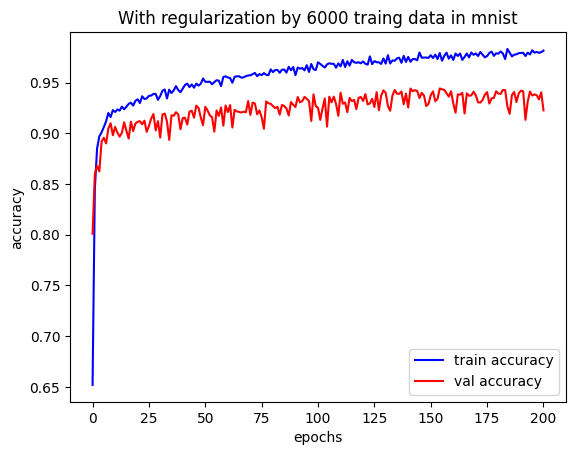

In [44]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
#1
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# subsampling for overfitting
n_sample = 6000
x_train = x_train[:n_sample]
y_train = y_train[:n_sample]

#2:normalize images
x_train = x_train.astype('float32')
x_test  = x_test.astype('float32')
x_train /= 255.0 # [0, 1]
x_test  /= 255.0

#3: one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train) # (n_sample, 10)
y_test = tf.keras.utils.to_categorical(y_test)   # (10000,    10)

#4: build a model without regularization
act = "relu"
init = "he_uniform"
n = 100
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
model.add(tf.keras.layers.Dense(units=n, activation=act, kernel_initializer = init))
model.add(tf.keras.layers.Dense(units=n, activation=act, kernel_initializer = init))
model.add(tf.keras.layers.Dense(units=10, activation='softmax'))
model.summary()

#4-1: configure the model for training
opt = 'rmsprop' # tf.keras.optimizers.RMSprop(learning_rate=0.001) 
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


logdir = './logs/' + "3401"

file_writer = tf.summary.create_file_writer(logdir + "/gradient")
file_writer.set_as_default()

#6:  calculate averages and histograms of gradients in layers
class GradientCallback(tf.keras.callbacks.Callback): 
  def __init__(self, freq=10):
##        super(GradientCallback, self).__init__()
      self.freq = freq

  def on_epoch_end(self, epoch, logs):
    if epoch%self.freq != 0:
        return

    with tf.GradientTape() as tape:
        y_pred = model(x_train)  # tensor, logits           
        loss   = tf.keras.losses.binary_crossentropy(y_train, y_pred)
    grads = tape.gradient(loss, model.trainable_weights)

    for n in range(1, len(model.layers)):
        i2 = (n-1)*2 # weights
        i1 = i2 + 1  # biases

        bias_avg   = tf.reduce_mean(tf.abs(grads[i1]))
        weight_avg = tf.reduce_mean(tf.abs(grads[i2]))
        
        tf.summary.scalar("layer_%d/avg/bias"%n, data=bias_avg, step=epoch)   
        tf.summary.scalar("layer_%d/avg/weight"%n, data=weight_avg, step=epoch)
        
        tf.summary.histogram("layer_%d/hist/bias"%n, data=grads[i1], step=epoch)
        tf.summary.histogram("layer_%d/hist/weight"%n, data=grads[i2], step=epoch)

        tf.print('epoch: {}, layer-{}, i1: {}, i2: {}'.format(epoch, n, i1, i2))
    
    feature_extractor = keras.Model(
        inputs=model.inputs,
        outputs=[layer.output for layer in model.layers],
    )
    features = feature_extractor(x_train)
    for i, f in enumerate(features):
      print('type_i: {}, type_f: {}'.format(type(i), type(f)))
      output_avg = tf.reduce_mean(tf.abs(f))
      tf.summary.scalar("layer_%d/avg/output"%i, data=output_avg, step=epoch)        
      tf.summary.histogram("layer_%d/hist/output"%i, data=f, step=epoch)
      
  def on_train_end(self, logs):
      tf.summary.flush()

callback1 = GradientCallback() # freq = 10
callback2 = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq= 10, profile_batch=0) 


#4-2: train and evaluate the model
ret = model.fit(x_train, y_train, epochs=101, batch_size=400,
                                  validation_data = (x_test, y_test), verbose=0, callbacks=[callback1, callback2])
 
train_loss, train_acc = model.evaluate(x_train, y_train, verbose=2)
test_loss, test_acc   = model.evaluate(x_test,  y_test, verbose=2)

#4-3: plot accuracies
plt.title("Without regularization by %s traing data in mnist"%n_sample)
plt.plot(ret.history['accuracy'],     "b-", label="train accuracy")
plt.plot(ret.history['val_accuracy'], "r-", label="val accuracy")
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(loc="best")
plt.show()

#5: build a model with weight regularization
reg = tf.keras.regularizers.l2(0.01)  # L2: 0.01, 0.1, 0.5
model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
model2.add(tf.keras.layers.Dense(units=n, activation=act, kernel_initializer = init,
                                 kernel_regularizer=reg))
model2.add(tf.keras.layers.Dense(units=n, activation=act, kernel_initializer = init,
                                 kernel_regularizer=reg))
model2.add(tf.keras.layers.Dense(units=10, activation='softmax'))
model2.summary()
 
#5-1: configure the model for training
model2.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
                                 
#5-2: train and evaluate the model
ret2 = model2.fit(x_train, y_train, epochs=201, batch_size=400,
                                    validation_data = (x_test, y_test), verbose=0, callbacks=[callback1, callback2])
train_loss2, train_acc2 = model2.evaluate(x_train, y_train, verbose=2)
test_loss2,  test_acc2  = model2.evaluate(x_test,  y_test,  verbose=2)

#5-3: plot accuracy
plt.title("With regularization by %s traing data in mnist"%n_sample)
plt.plot(ret2.history['accuracy'],     "b-", label="train accuracy")
plt.plot(ret2.history['val_accuracy'], "r-", label="val accuracy")
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(loc="best")
plt.show()


In [46]:
%tensorboard --logdir ./logs/3401 --port 6014

Launching TensorBoard...

# Step35 Dropout


<img src="https://laid.delanover.com/wp-content/uploads/2018/02/dropout.png" width="400"/>


Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_20 (Flatten)        (None, 784)               0         
                                                                 
 dense_120 (Dense)           (None, 100)               78500     
                                                                 
 dropout_4 (Dropout)         (None, 100)               0         
                                                                 
 dense_121 (Dense)           (None, 100)               10100     
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 dense_122 (Dense)           (None, 10)                1010      
                                                                 
Total params: 89,610
Trainable params: 89,610
Non-tra

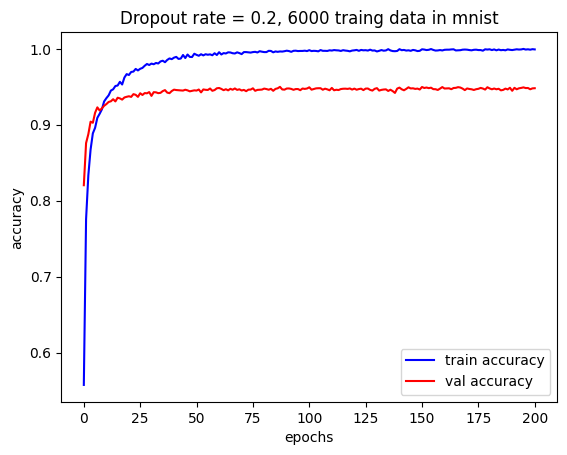

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
#1
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# subsampling for overfitting
n_sample = 6000
x_train = x_train[:n_sample]
y_train = y_train[:n_sample]

#2:normalize images
x_train = x_train.astype('float32')
x_test  = x_test.astype('float32')
x_train /= 255.0 # [0, 1]
x_test  /= 255.0

#3: one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train) # (n_sample, 10)
y_test = tf.keras.utils.to_categorical(y_test)   # (10000,    10)

#4: build a model with dropout
act = "relu"
init = "he_uniform"

n = 100
dropout_rate = 0.2  # 0.5
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
model.add(tf.keras.layers.Dense(units=n, activation=act, kernel_initializer = init))
model.add(tf.keras.layers.Dropout( rate=dropout_rate))

model.add(tf.keras.layers.Dense(units=n, activation=act, kernel_initializer = init))
model.add(tf.keras.layers.Dropout( rate=dropout_rate))

model.add(tf.keras.layers.Dense(units=10, activation='softmax'))
model.summary()

#4-1: configure the model for training
##opt = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])


logdir = './logs/' + "3501"

file_writer = tf.summary.create_file_writer(logdir + "/gradient")
file_writer.set_as_default()

#6:  calculate averages and histograms of gradients in layers
callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq= 10, profile_batch=0) 


#4-2: train and evaluate the model
ret = model.fit(x_train, y_train, epochs=201, batch_size=400,
                                  validation_data = (x_test, y_test), verbose=0, callbacks=[callback])
 
train_loss, train_acc = model.evaluate(x_train, y_train, verbose=2)
test_loss, test_acc   = model.evaluate(x_test,  y_test, verbose=2)

#4-3: plot accuracies
plt.title("Dropout rate = %s, %s traing data in mnist"%(dropout_rate, n_sample))
plt.plot(ret.history['accuracy'],     "b-", label="train accuracy")
plt.plot(ret.history['val_accuracy'], "r-", label="val accuracy")
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(loc="best")
plt.show()


In [ ]:
%tensorboard --logdir ./logs/3501 --port 6015